### Common Imports

In [1]:
import math
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt

## Task 1 - Identify Features

- **Assemble a dataset consisting of features and target:**

In [2]:
# Read in all vehicle data
vehicle_data = pd.read_csv('./vehicles.csv')

In [3]:
# Print basic info
data_shape = vehicle_data.shape
print(f'Data has {data_shape[0]:,} rows and {data_shape[1]} columns')

Data has 509,577 rows and 25 columns


In [4]:
# Separate data into raw features and target
target_col = 'price'
raw_features = vehicle_data.drop(columns=target_col)
raw_target = vehicle_data.price

- **What features are relevant for the prediction task?**

Certainly features that are entirely **empty** cannot be informative:

In [5]:
empty_features = raw_features.columns[raw_features.isna().all()].to_list()
print('Entirely empty features:', empty_features)

Entirely empty features: ['county']


Based purely on the **column descriptions**, some features will likely be irrelevant to predict price.  
**Note**: we may end up extracting new features from some of these dropped columns later on.

In [6]:
irrelevant_features = ['url', 'vin', 'image_url']

To get a sense of how relevant the remaining features may be to predict price, we can **visualize their relationship to the target value**:

In [7]:
relevant_features = raw_features.columns.difference(empty_features+irrelevant_features, sort=False)
relevant_types = raw_features.dtypes[relevant_features]

Our visualizations won't be very effective if outlier prices ruin the scaling.  Let's look at the distribution of prices in the data:

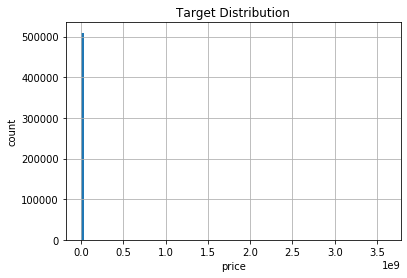

In [8]:
raw_target.hist(bins=100)
plt.title('Target Distribution')
plt.xlabel('price')
plt.ylabel('count');

Looking at the scale of the x-axis, there are clearly some **outlier prices** that will disrupt the scaling of our visualizations.  To prevent this, we'll limit our visualizations to prices greater than 0 and within the 99.9th percentile of the distribution:

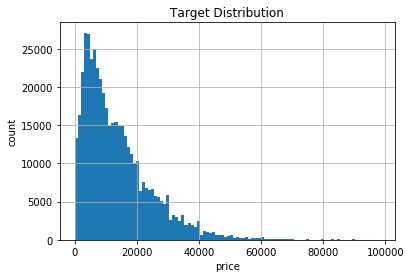

In [9]:
valid_price_rows = (raw_target > 0) & (raw_target < raw_target.quantile(.999))

# Replot the histogram
raw_target[valid_price_rows].hist(bins=100)
plt.title('Target Distribution')
plt.xlabel('price')
plt.ylabel('count');

That looks like a much smoother distribution of used vehicle prices.  Now we can visualize the features' relationship to the target:

##### Continuous Features vs. Target

In [10]:
continuous_features = relevant_features[relevant_types != 'object']

NameError: name 'num_cont_feats' is not defined

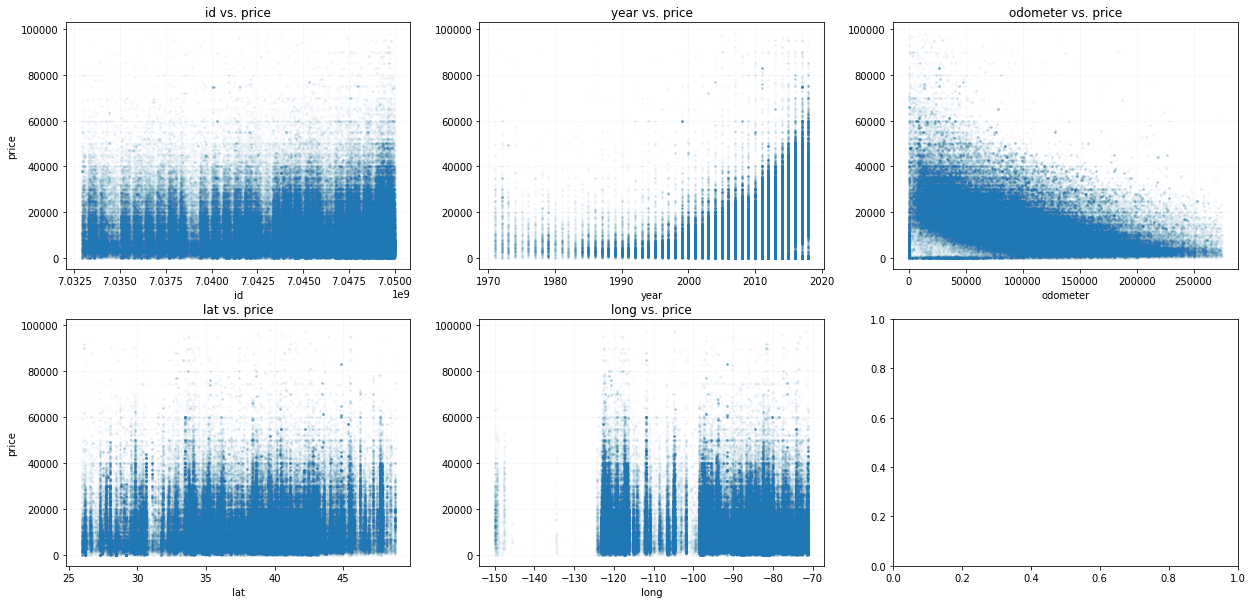

In [11]:
# Figure out an appropriate number of rows and columns
num_plots = len(continuous_features)
plot_cols = 3
plot_rows = math.ceil(num_plots / plot_cols)

# For each continuous feature...
fig, axs = plt.subplots(plot_rows, plot_cols, figsize=(7*plot_cols, 5*plot_rows), squeeze=False)
for i, feature in enumerate(continuous_features):
    # Get the axes for this feature
    row=i//plot_cols
    col=i%plot_cols
    ax=axs[row,col]
    
    # Decide which rows to plot for this feature
    # To avoid outliers distorting the scale of the x-axis, we'll ignore data below the 1st percentile
    # or above the 99th percentile.
    feature_col = raw_features[feature]
    feature_rows = (feature_col > feature_col.quantile(.01)) & (feature_col < feature_col.quantile(.99))
    rows_to_plot = valid_price_rows & feature_rows
    
    # Create a scatter plot for this feature vs. target
    ax.scatter(feature_col[rows_to_plot], raw_target[rows_to_plot], s=3, alpha=0.02)
    ax.grid(alpha=0.1)
    ax.set_axisbelow(True)
    
    # Label the plot
    ax.set_title(feature+' vs. price')
    ax.set_xlabel(feature)
    if col==0:
        ax.set_ylabel('price')
        
# Hide any axis we didn't use
num_axes_to_hide = plot_rows*plot_cols - num_cont_feats
for i in range(num_axes_to_hide):
    axs.flatten()[-(i+1)].set_axis_off()

From these plots, we conclude the following:
- both 'year' and 'odometer' have strong correlations with 'price' (although in opposite directions)
- 'id' may have a weak positive correlation with 'price'.
- 'lat' and 'long' by themselves do not appear to have a specific relationship to 'price'.  These may require more advanced feature engineering to extract predictive information.

In [12]:
uninformative_features = ['lat', 'long']

##### Ordinal Features vs. Target

The remaining features are **discrete** (non-continuous):

In [13]:
relevant_features.difference(continuous_features, sort=False)

Index(['region', 'region_url', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color', 'description', 'state'],
      dtype='object')

The provided descriptions of these features suggest several of them (condition, cylinders, and size) are **ordinal** in nature (ordered): 

In [14]:
ordinal_features = pd.Index(['condition', 'cylinders', 'size'])

Determine the distinct values of these features and provide an appropriate ordering for them using domain knowledge:

In [15]:
raw_features['condition'].unique().tolist()

['excellent', nan, 'good', 'like new', 'fair', 'new', 'salvage']

In [16]:
conditions = ['salvage', 'fair', 'good', 'excellent', 'like new', 'new']

In [17]:
raw_features['cylinders'].unique().tolist()

['4 cylinders',
 nan,
 '8 cylinders',
 '6 cylinders',
 '10 cylinders',
 '5 cylinders',
 '3 cylinders',
 '12 cylinders',
 'other']

In [18]:
cylinders = ['3 cylinders', '4 cylinders', '5 cylinders', '6 cylinders', '8 cylinders', '10 cylinders', '12 cylinders', 'other']

In [19]:
raw_features['size'].unique().tolist()

['compact', nan, 'mid-size', 'full-size', 'sub-compact']

In [20]:
sizes = ['sub-compact', 'compact', 'mid-size', 'full-size']

We can now convert these ordinal features into ordered Pandas categories:

In [21]:
ordinals_dict = {'condition':conditions, 'cylinders':cylinders, 'size':sizes}

for feature, ordered_values in ordinals_dict.items():
    cat_type = CategoricalDtype(categories=ordered_values, ordered=True)
    vehicle_data[feature] = vehicle_data[feature].astype(cat_type)

Let's visualize the target response to these ordinal features to see if there is the expected monotonic relationship:

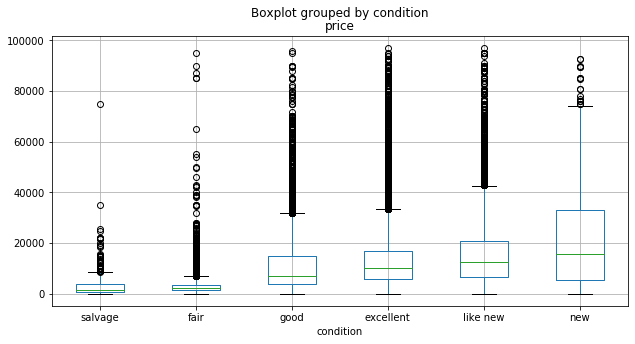

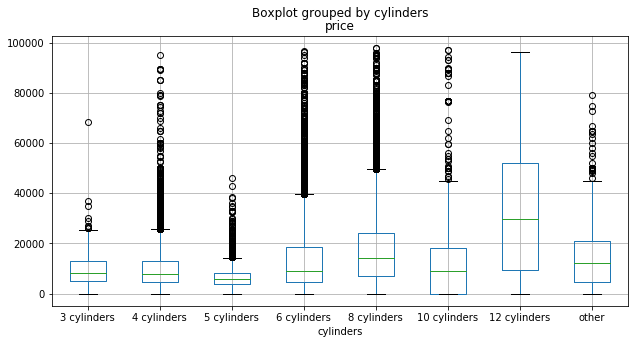

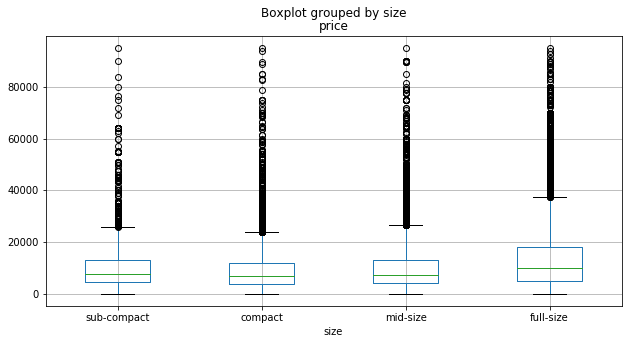

In [22]:
# For each ordinal feature...
for feature in ordinal_features:  
    # Create a box plot for this feature vs. target
    vehicle_data.loc[valid_price_rows, :].boxplot(column='price', by=feature, figsize=(10, 5))

For these plots, we conclude the following:
- Condition is a strong indicator for price. We can clearly see the increasing trend when the condition of the car is better.
- Neither 'cylinders' nor 'size' show the expected monotonic relation for an ordinal feature.
 - For example, the average price for 5-cylinder vehicles is less than that of 4-cylinder vehicles, and similarly for 10 vs. 8 cylinders.
 - There is not a significant change in the distribution of prices for sub-compact, compact, or mid-size vehicles.
 
 
 Therefore, we'll only consider 'condition' as an ordinal feature:

In [23]:
ordinal_features = pd.Index(['condition'])

##### Categorical Features vs. Target

In [24]:
categorical_features = relevant_features.difference(continuous_features.union(ordinal_features), sort=False)

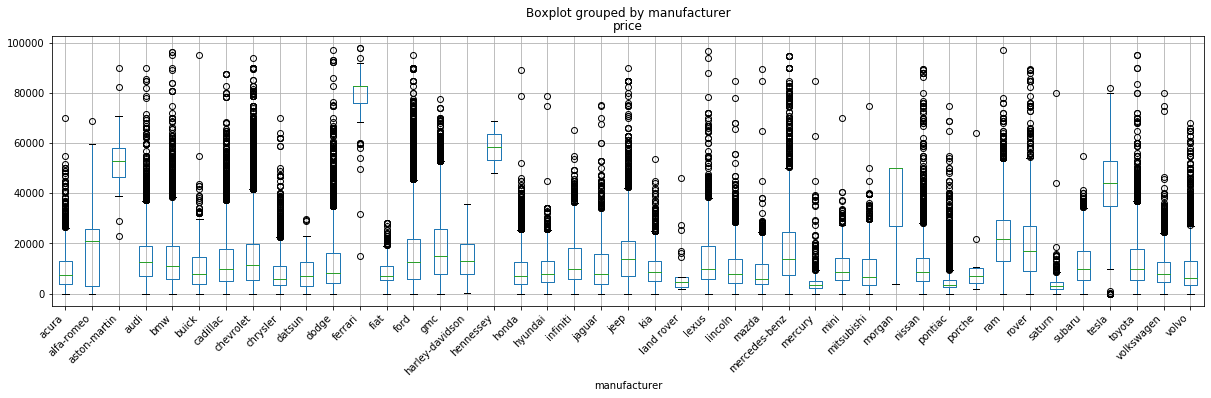

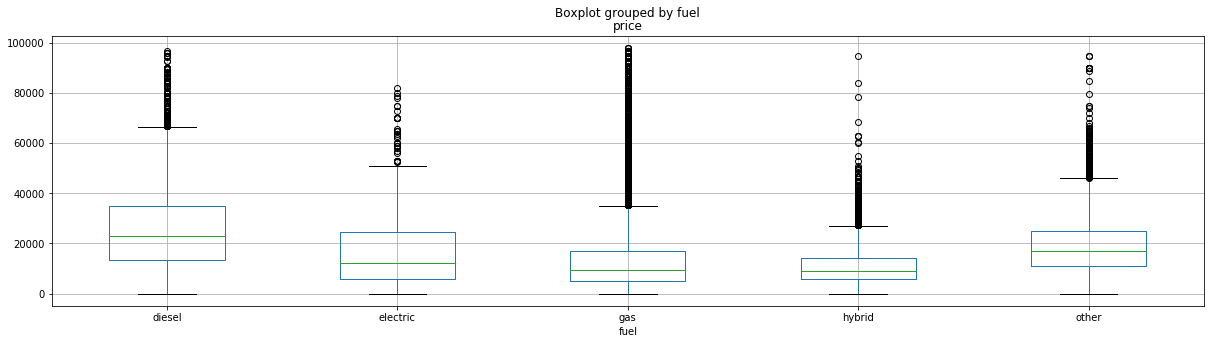

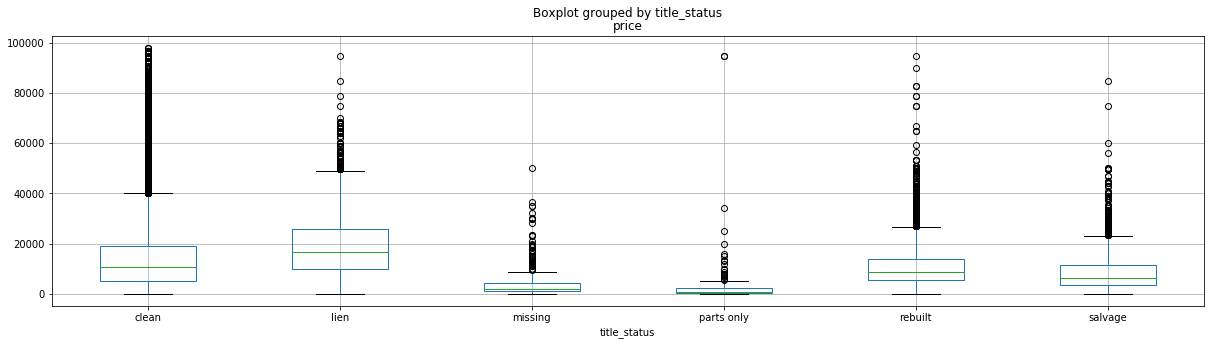

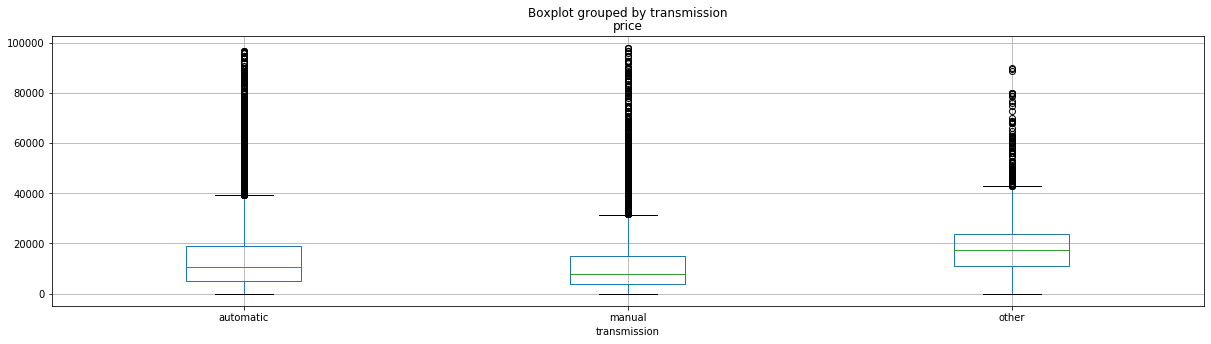

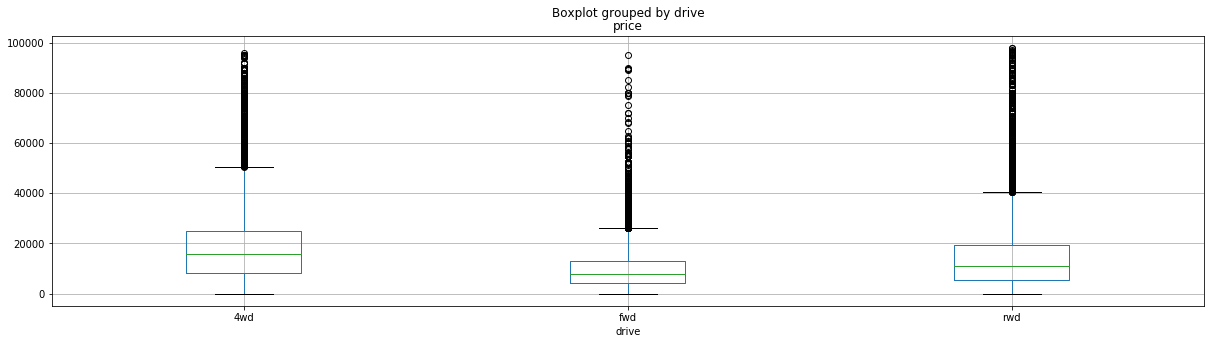

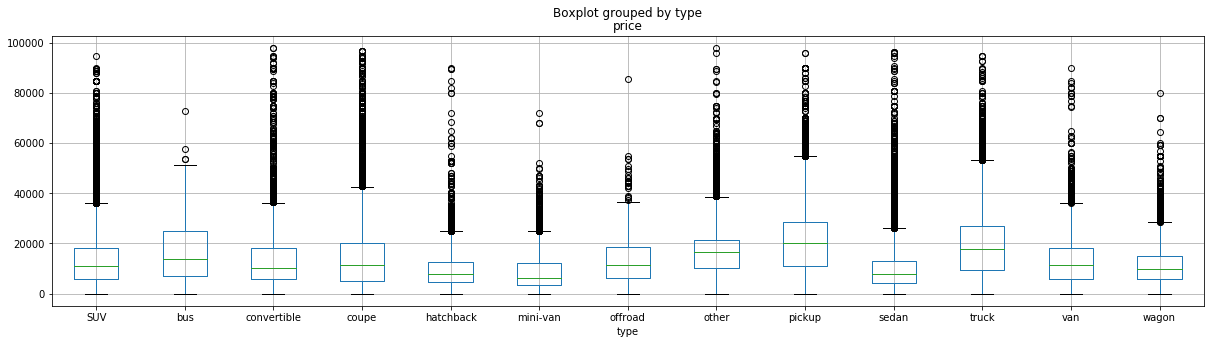

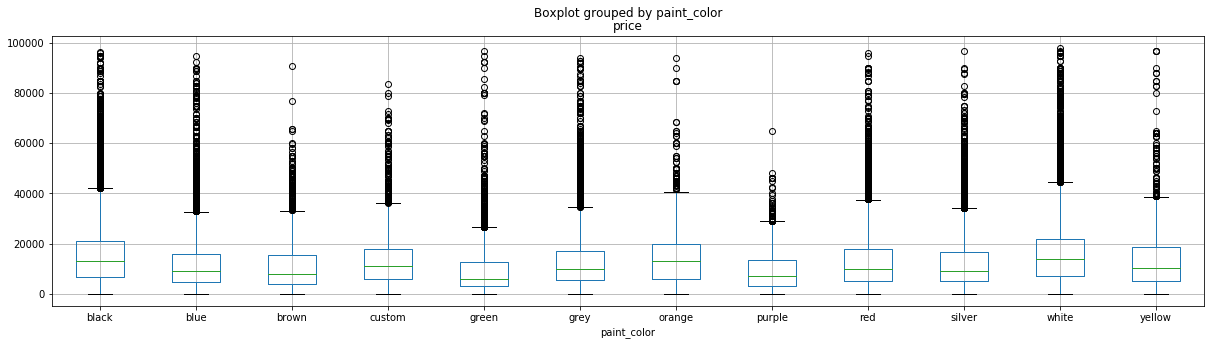

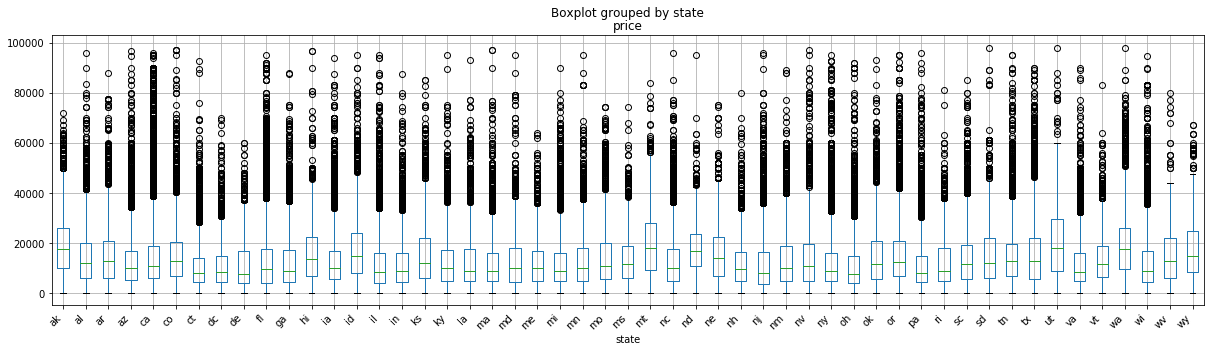

In [25]:
low_card_features = [feat for feat in categorical_features if vehicle_data[feat].nunique() < 52]

for feature in low_card_features:
    # We've already shown boxplots for 'cylinders' and 'size' above, so we don't need to see them again
    if feature in ['cylinders', 'size']: continue
    
    ax = vehicle_data.loc[valid_price_rows, :].boxplot(column='price', by=feature, figsize=(20, 5))
    if len(ax.get_xticklabels()) > 40:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

For these plots, we conclude the following:
- We can see logical trends in the manufacturer feature: cars like Ferrari, Tesla or Aston Martin are more expensive than the rest. We see some strange things as well, like the low price of Land Rovers, but overall the trend could be useful.
- As expected, diesel car are more expensive than the rest on average. The car market runs that way as well.
- Title status "missing" and "parts only" are much lower on average than the rest, as expected. We can see a good trend in this feature with respect to the price.
- As expected, automatic transmission cars are more expensive than manual cars. The "other" category here is not clear, but it's just 4% of the data.
- Following the trend of the market, 4wd cars are more expensive than the others. This feature proves to be useful for classification.
- In vehicle type, we cannot see a very clear trend, but we can find many differences, that can make us go one way or the other with confidence when classifying. This feature will be used for modelling the data.
- On the real car market, paint color is a variable over the price of a car (e.g. red Ferraris are more expensive than other colors). In this data is not as clear as we would like, but the most popular colors (black and white) are higher on average, showing useful trends.
- States don't show a very highly marked trend, but we think that it will give us useful insight when combined with other variables, so we will keep it.

Regarding the remaining categorical features, it is unhelpful to plot them due to the sheer number of categories. For example, 'model' is a really dirty feature which needs heavy and complex cleaning before being a useful source of information. Other high-cardinality categorical variables, like 'region', are possible candidates for Target Encoding.

In [26]:
dirty_features = ['model']

- **Are there any features that should be excluded because they leak the target information?**

We noticed that the '**description**' column could possibly leak some target information, as it occassionally contains pricing information.  
For example, the following are excerpts from entries in the 'description' column, along with the actual target value:  
- "...I am asking $39,500 for this awesome truck..." (price=39,500)

- "...asking $1000 or best offer..." (price=1,000)

- "...asking $23400 or best offer..." (price=23,400)

In [27]:
leaky_features = ['description']

#### Region analysis
In inspecting the data, we noticed that the '**region**' column might not be specific enough to identify the actual region of the vehicle due to the same city name existing in multiple states.  We see evidence of this when comparing the 'region' column to the '**region_url**' column, which appears to make more distinctions.  The following are a few examples of where 'region' is duplicated:

| **region** | **region_url**                      |
|------------|-------------------------------------|
| albany     | https://albany.craigslist.org       |
| albany     | https://albanyga.craigslist.org     |
| athens     | https://athensga.craigslist.org     |
| athens     | https://athensohio.craigslist.org   |
| charleston | https://charleston.craigslist.org   |
| charleston | https://charlestonwv.craigslist.org |
| columbus   | https://columbus.craigslist.org     |
| columbus   | https://columbusga.craigslist.org   |

As '**region_url**' is a more specific version of the '**region**' feature and more accurately defines the true location of the vehicle, we're going to drop the 'region' feature and use only 'region_url'.

In [28]:
unspecific_features = ['region']

#### Conclusions

From the above analyses, we're going to **drop** the following features for our baseline model:
- 'county' (entirely empty)
- 'url' (irrelevant as is, but we may extract features from it in subsequent steps)
- 'image_url' and 'vin' (irrelevant)
- 'lat' and 'long' (requires feature engineering to be informative)
- 'description' (could leak target information, but we may extract features from it in subsequent steps)
- 'region' ('region_url' is more accurate)
- 'model' (requires extensive cleanup before it will be useful)

In [29]:
features_to_drop = empty_features + irrelevant_features + uninformative_features + leaky_features + unspecific_features + dirty_features
print('Features to drop for Baseline model:', features_to_drop)

Features to drop for Baseline model: ['county', 'url', 'vin', 'image_url', 'lat', 'long', 'description', 'region', 'model']


## Task 2 - Preprocessing and Baseline Model

- **Create a simple minimum viable model by doing an initial selection of features, doing appropriate preprocessing and cross-validating a linear model.**

In [30]:
baseline_features = raw_features.columns.difference(features_to_drop, sort=False)
baseline_features

Index(['id', 'region_url', 'year', 'manufacturer', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color', 'state'],
      dtype='object')

#### Prepare Baseline Preprocessing

In [31]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
import category_encoders as ce

# Prepare transformation pipelines for different column types
target_encode_pl = make_pipeline(ce.TargetEncoder(), StandardScaler())
median_scale_pl = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
new_cat_ohe_pl = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder(handle_unknown='ignore'))
impute_good_ord_enc_scale_pl = make_pipeline(SimpleImputer(strategy='constant', fill_value='good'), OrdinalEncoder(categories=[conditions]), StandardScaler())
most_freq_ohe_pl = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore'))

# Contruct our baseline preprocessing transformation
baseline_preprocessor = make_column_transformer(
    (StandardScaler(), ['id']),
    (target_encode_pl, ['region_url']),
    (median_scale_pl, ['year', 'odometer']),
    (new_cat_ohe_pl, ['manufacturer', 'cylinders', 'drive', 'size', 'type', 'paint_color', 'state']),
    (impute_good_ord_enc_scale_pl, ['condition']),
    (most_freq_ohe_pl, ['fuel', 'title_status', 'transmission']))

- **You don't need to validate the model on the whole dataset.**

In [32]:
# TODO: Drop rows missing many features???

In [33]:
from sklearn.model_selection import train_test_split

# We'll train and test only on the rows with a valid price
X = raw_features.loc[valid_price_rows,:]
y = raw_target[valid_price_rows]

# Set aside a test set for final evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=25)
print('X_train rows:', X_train.shape[0])
print('X_test rows:', X_test.shape[0])

X_train rows: 349115
X_test rows: 116372


#### Baseline model evaluation
In the following block, we'll generate a baseline score for four different linear regressions: OLS, Ridge, Lasso and ElasticNet.

In [34]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import ShuffleSplit, cross_val_score

In [35]:
# Use a ShuffleSplit object to sub-sample the training data for faster cross validataion
shuffle = ShuffleSplit(n_splits=10, train_size=50000, test_size=10000, random_state=25)

In [37]:
# Gather baseline cross validation scores for some linear models
#baseline_ols_pipeline = make_pipeline(baseline_preprocessor, LinearRegression())
#baseline_ols_scores = cross_val_score(baseline_ols_pipeline, X_train, y_train, cv=shuffle)
#print(("Baseline model using OLS regression score: %f") % baseline_ols_scores.mean())

baseline_ridge_pipeline = make_pipeline(baseline_preprocessor, RidgeCV())
baseline_ridge_scores = cross_val_score(baseline_ridge_pipeline, X_train, y_train, cv=shuffle)
print(("Baseline model using Ridge regression score: %f") % baseline_ridge_scores.mean())

#baseline_lasso_pipeline = make_pipeline(baseline_preprocessor, LassoCV())
#baseline_lasso_scores = cross_val_score(baseline_lasso_pipeline, X_train, y_train, cv=shuffle)
#print(("Baseline model using Lasso regression score: %f") % baseline_lasso_scores.mean())

#baseline_en_pipeline = make_pipeline(baseline_preprocessor, ElasticNetCV())
#baseline_en_scores = cross_val_score(baseline_en_pipeline, X_train, y_train, cv=shuffle)
#print(("Baseline model using ElasticNet regression score: %f") % baseline_en_scores.mean())

Baseline model using Ridge regression score: 0.417622


## Task 3 - Feature Engineering

## WORK IN PROGRESS...

### Explore different Pre-Processing for Continuous features

Taking a look at histograms for the continuous features, there appear to be significant outliers present:

/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


NameError: name 'num_cont_feats' is not defined

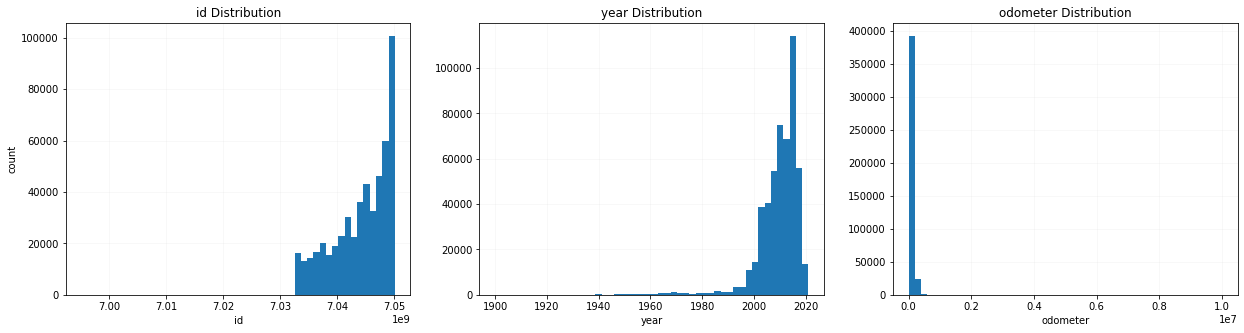

In [38]:
# Figure out an appropriate number of rows and columns
cont_baseline_feats = continuous_features.intersection(baseline_features)
num_plots = len(cont_baseline_feats)
plot_cols = 3
plot_rows = math.ceil(num_plots / plot_cols)
fig, axs = plt.subplots(plot_rows, plot_cols, figsize=(7*plot_cols, 5*plot_rows), squeeze=False)

# For each continuous feature...
for i, feature in enumerate(cont_baseline_feats):
    # Get the axes for this feature
    row=i//plot_cols
    col=i%plot_cols
    ax=axs[row,col]
        
    # Create a histogram for this feature
    ax.hist(raw_features[feature], bins=50)
    ax.grid(alpha=0.1)
    ax.set_axisbelow(True)
    
    # Label the plot
    ax.set_title(feature+' Distribution')
    ax.set_xlabel(feature)
    if col==0:
        ax.set_ylabel('count')
        
# Hide any axis we didn't use
num_axes_to_hide = plot_rows*plot_cols - num_cont_feats
for i in range(num_axes_to_hide):
    axs.flatten()[-(i+1)].set_axis_off()

It looks like some of this data may be invalid, especially for 'odometer', whose upper range is extremently high.

**Idea**: The first thing we could try is to simply use a **RobustScaler()** instead of the StandardScaler(), which is more robust to outlier values:

In [39]:
# Form a pipline using RobustScaler
from sklearn.preprocessing import RobustScaler
median_robust_scale_pl = make_pipeline(SimpleImputer(strategy='median'), RobustScaler())

# Try preprocessing with RobustScaler
preprocessor = make_column_transformer(
    (RobustScaler(), ['id']),
    (target_encode_pl, ['region_url']),
    (median_robust_scale_pl, ['year', 'odometer']),
    (new_cat_ohe_pl, ['manufacturer', 'cylinders', 'drive', 'size', 'type', 'paint_color', 'state']),
    (impute_good_ord_enc_scale_pl, ['condition']),
    (most_freq_ohe_pl, ['fuel', 'title_status', 'transmission']))

# Compare the Ridge results to the baseline
pipeline = make_pipeline(preprocessor, RidgeCV())
scores = cross_val_score(pipeline, X_train, y_train, cv=shuffle)
print(("Ridge regression score: %f") % scores.mean())

Ridge regression score: 0.417622


**Result**: Using RobustScaler didn't appear to have any impact

---

**Idea**: A different approach would be to just **cap extreme values** to a certain percentile prior to scaling.  For example, treat any value greater than the 99th percentile equivalent to the 99th percentile value.

Below is a function that caps the values in a Pandas Series or DataFrame to be between the 1st and 99th percentile of the input data:

In [40]:
def cap_extreme_values(X):
    upper_cap = X.quantile(.99)
    lower_cap = X.quantile(.01)
    ax = 1 if isinstance(X, pd.DataFrame) else None
    X = X.mask(X>upper_cap, upper_cap, axis=ax)
    X = X.mask(X<lower_cap, lower_cap, axis=ax)
    return X

We can visualize the effect of using such a preprocessing technique by re-plotting the capped histograms:

/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


NameError: name 'num_cont_feats' is not defined

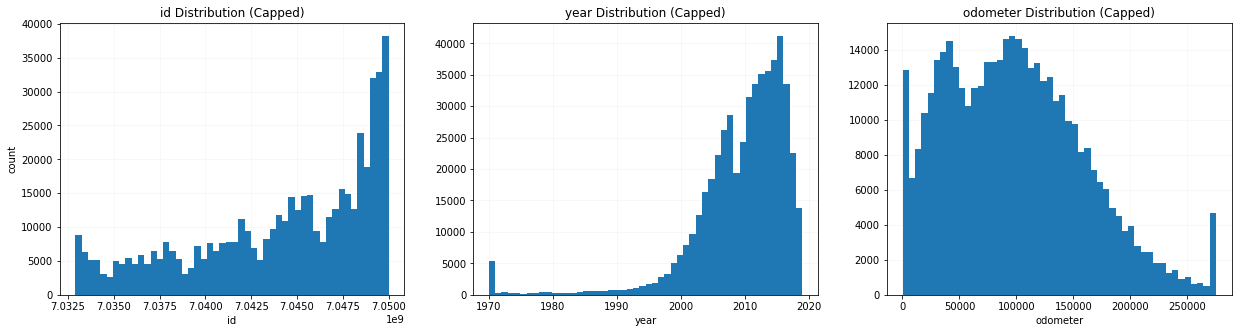

In [41]:
# For each continuous feature...
fig, axs = plt.subplots(plot_rows, plot_cols, figsize=(7*plot_cols, 5*plot_rows), squeeze=False)
for i, feature in enumerate(cont_baseline_feats):
    # Get the axes for this feature
    row=i//plot_cols
    col=i%plot_cols
    ax=axs[row,col]
        
    # Create a histogram for this feature
    ax.hist(cap_extreme_values(raw_features[feature]), bins=50)
    ax.grid(alpha=0.1)
    ax.set_axisbelow(True)
    
    # Label the plot
    ax.set_title(feature+' Distribution (Capped)')
    ax.set_xlabel(feature)
    if col==0:
        ax.set_ylabel('count')
        
# Hide any axis we didn't use
num_axes_to_hide = plot_rows*plot_cols - num_cont_feats
for i in range(num_axes_to_hide):
    axs.flatten()[-(i+1)].set_axis_off()

These distributions look far smoother.  For example, the incredibly high odometer readings have all been capped to around 275,000 miles.  Any values above that will be treated equivalently to this maximum.

Let's see if this capping has any effect on the accuracy of the model:

In [42]:
# Make a Transformer that uses cap_extreme_values()
capper = FunctionTransformer(cap_extreme_values)

# Make new pipelines for incorporating the capping of these continuous values
cap_scale_pl = make_pipeline(capper, StandardScaler())
cap_median_scale_pl = make_pipeline(capper, SimpleImputer(strategy='median'), StandardScaler())

# Try this updated preprocessing
preprocessor = make_column_transformer(
    (cap_scale_pl, ['id']),
    (target_encode_pl, ['region_url']),
    (cap_median_scale_pl, ['year', 'odometer']),
    (new_cat_ohe_pl, ['manufacturer', 'cylinders', 'drive', 'size', 'type', 'paint_color', 'state']),
    (impute_good_ord_enc_scale_pl, ['condition']),
    (most_freq_ohe_pl, ['fuel', 'title_status', 'transmission']))

# Compare the Ridge results to the baseline
pipeline = make_pipeline(preprocessor, RidgeCV())
scores = cross_val_score(pipeline, X_train, y_train, cv=shuffle)
print(("Ridge regression score: %f") % scores.mean())

Ridge regression score: 0.524588


**Result**: Capping the extreme values made a **significant improvement** over the baseline Ridge score of 0.417622

---

**Idea**: An extension of the above idea would be to fully **bin or discretize** the continuous variables, esentially transforming them into categorical variables.

To do this, we'll experiment with the **KBinsDiscretizer** transformer:

In [53]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import GridSearchCV
binner = KBinsDiscretizer(n_bins=10, encode='onehot-dense', strategy='quantile')

# Make a new pipeline for incorporating the binning of these continuous values
median_bin_pl = make_pipeline(SimpleImputer(strategy='median'), binner)

# Try this updated preprocessing
preprocessor = make_column_transformer(
    (binner, ['id']),
    (target_encode_pl, ['region_url']),
    (median_bin_pl, ['year', 'odometer']),
    (new_cat_ohe_pl, ['manufacturer', 'cylinders', 'drive', 'size', 'type', 'paint_color', 'state']),
    (impute_good_ord_enc_scale_pl, ['condition']),
    (most_freq_ohe_pl, ['fuel', 'title_status', 'transmission']))

# Compare the Ridge results to the baseline
pipeline = make_pipeline(preprocessor, RidgeCV())
param_grid = {'columntransformer__kbinsdiscretizer__n_bins': range(5, 15)}
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=shuffle, return_train_score=True)
grid.fit(X_train, y_train)
score = grid.best_score_
best_n_bins = grid.best_params_['columntransformer__kbinsdiscretizer__n_bins']
print(("Ridge regression score: %f") % score)
print(("Best number of bins %d") % best_n_bins)

Ridge regression score: 0.613599
Best number of bins 14.000000


{'columntransformer__kbinsdiscretizer__n_bins': 14}


**Result**: Discretizing the continuous features made an **even greater improvement** over the baseline Ridge score of 0.417622

---

### Explore using a Target Transformation

In [ ]:
from sklearn.compose import TransformedTargetRegressor
# Try converting prices to log
print("Testing same regressors but with logarithm of price:")
ridge_log_regressor = TransformedTargetRegressor(RidgeCV(), func=np.log, inverse_func=np.exp)
baseline_ridge_pipeline = make_pipeline(baseline_preprocessor, ridge_log_regressor)
baseline_ridge_scores = cross_val_score(baseline_ridge_pipeline, X_train, y_train)
print(("Baseline model using Ridge regression score: %f") % baseline_ridge_scores.mean())

ols_log_regressor = TransformedTargetRegressor(LinearRegression(), func=np.log, inverse_func=np.exp)
baseline_ols_pipeline = make_pipeline(baseline_preprocessor, ols_log_regressor)
baseline_ols_scores = cross_val_score(baseline_ols_pipeline, X_train, y_train)
print(("Baseline model using OLS regression score: %f") % baseline_ols_scores.mean())

lasso_log_regressor = TransformedTargetRegressor(LassoCV(), func=np.log, inverse_func=np.exp)
baseline_lasso_pipeline = make_pipeline(baseline_preprocessor, lasso_log_regressor)
baseline_lasso_scores = cross_val_score(baseline_lasso_pipeline, X_train, y_train)
print(("Baseline model using Lasso regression score: %f") % baseline_lasso_scores.mean())

en_log_regressor = TransformedTargetRegressor(ElasticNetCV(), func=np.log, inverse_func=np.exp)
baseline_en_pipeline = make_pipeline(baseline_preprocessor, en_log_regressor)
baseline_en_scores = cross_val_score(baseline_en_pipeline, X_train, y_train)
print(("Baseline model using ElasticNet regression score: %f") % baseline_en_scores.mean())